# Advanced Topics on Sinkhorn Algorithm

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/gpeyre/ot4ml/blob/main/python/3-sinkhorn-advanced.ipynb)

This numerical tour explore several extensions of the basic Sinkhorn
method.

In [ ]:
using LinearAlgebra
using Plots

Log-domain Sinkhorn
--------------------

For simplicity, we consider **uniform distributions** on point clouds. This means that the associated histograms $a \in \mathbb{R}^n$ and $b \in \mathbb{R}^m$ are constant vectors:
$$
a_i = \frac{1}{n}, \quad b_j = \frac{1}{m}, \quad \text{for all } i, j.
$$

This assumption simplifies the computation and ensures that the marginals are valid probability distributions over $n$ and $m$ points, respectively.

In [ ]:
n = 100
m = 200
a = ones(n,1) ./ n
b = ones(1,m) ./ m;

Point clouds $x$ and $y$.

In [ ]:
x = rand(2,n) .- .5
theta = 2*pi .* rand(1,m)
r = .8 .+ .2 .* rand(1,m)
y = vcat(cos.(theta) .* r, sin.(theta) .* r);

Display of the two clouds.

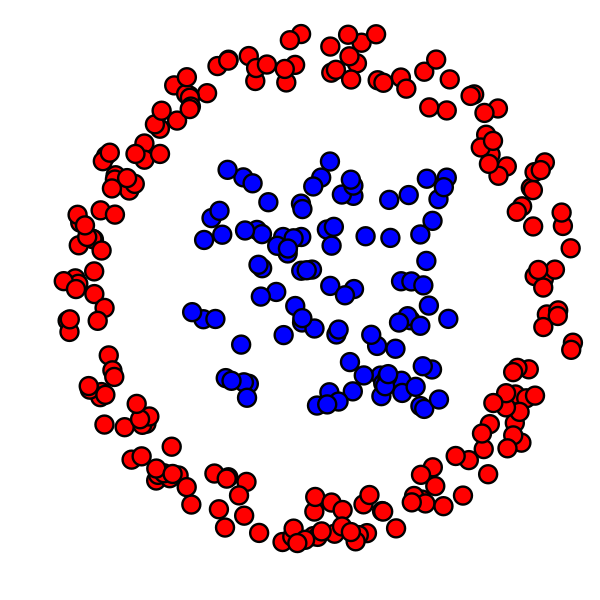

In [ ]:
function plotp!(plt, x, col)
    scatter!(
        plt,
        x[1,:],
        x[2,:],
        markersize=10,
        markercolor=col,
        markerstrokewidth=2,
        legend=false
    )
end
plt = plot(size=(600, 600), aspect_ratio=:equal, border=:none)
plotp!(plt, x, :blue)
plotp!(plt, y, :red)

The **cost matrix** is defined using the squared Euclidean distance between the points of the two point clouds:
$$
C_{i,j} = \|x_i - y_j\|^2,
$$
where $x_i \in

In [ ]:
function distmat(x, y)
    sumsq_x = sum(abs2, x, dims=1)
    sumsq_y = sum(abs2, y, dims=1)
    return sumsq_x' .+ sumsq_y .- 2 .* x' * y
end
C = distmat(x, y);

The original Sinkhorn algorithm relies on matrix-vector multiplications involving the kernel
$$
K = \exp\left( -\frac{C}{\epsilon} \right),
$$
which can lead to numerical instability when $\epsilon$ is small (due to underflow or division by very small numbers).

To address this, we use a **log-domain implementation** of Sinkhorn, which is numerically stable and operates in terms of the **Kantorovich dual potentials** $(f, g) \in \mathbb{R}^n \times \mathbb{R}^m$.

The updates of these dual potentials are based on the **regularized $c$-transform**, and are given by:
$$
f_i \leftarrow {\min}_\epsilon^b\left( C_{i,\cdot} - g \right),
$$
$$
g_j \leftarrow {\min}_\epsilon^a\left( C_{\cdot,j} - f \right),
$$
where the **regularized minimum operator** is defined as:
$$
{\min}_\epsilon^a(h) := -\epsilon \log\left( \sum_i a_i \exp\left( -\frac{h_i}{\epsilon} \right) \right).
$$

This approach avoids forming the kernel matrix $K$ explicitly and maintains numerical stability for small $\epsilon$.

In [ ]:
mina_u(H, epsilon) = -epsilon .* log.( sum( a .* exp.(-H ./ epsilon), dims=1))
minb_u(H, epsilon) = -epsilon .* log.( sum( b .* exp.(-H ./ epsilon), dims=2));

The regularized minimum operator defined above can suffer from numerical instability, especially when the values of $h$ are large in magnitude.

To address this, we use the celebrated **log-sum-exp trick**, which provides a numerically stable way to evaluate expressions of the form:
$$
{\min}_\epsilon^a(h) := -\epsilon \log\left( \sum_i a_i \exp\left( -\frac{h_i}{\epsilon} \right) \right).
$$

The key idea is that this operator satisfies the identity:
$$
{\min}_\epsilon^a(h + c) = {\min}_\epsilon^a(h) + c \quad \text{for any constant } c \in \mathbb{R}.
$$

Therefore, to stabilize the computation, we choose:
$$
c = -\min(h),
$$
so that all exponentials inside the log are of the form $\exp(- (h_i - \min(h))/\epsilon )$, which are close to 1 and avoid underflow.

This simple adjustment greatly improves the numerical robustness of the algorithm when working with small $\epsilon$.

In [ ]:
mina(H, epsilon) = mina_u(H .- minimum(H, dims=1), epsilon) .+ minimum(H, dims=1)
minb(H, epsilon) = minb_u(H .- minimum(H, dims=2), epsilon) .+ minimum(H, dims=2);

Value of $\epsilon$.

In [ ]:
epsilon = .01;

We now implement Sinkhorn in log domain.

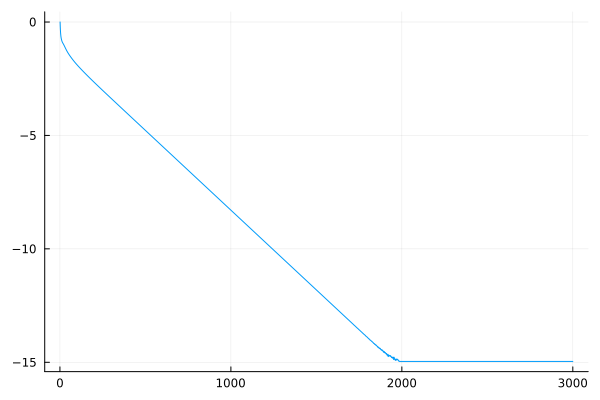

In [ ]:
function Sinkhorn(C, epsilon, f, niter=500)
    Err = zeros(niter)
    P = similar(C)
    for it in 1:niter
        g = mina(C .- f, epsilon)
        f = minb(C .- g, epsilon)
        # generate the coupling
        P .= a .* exp.((f .+ g .- C) ./ epsilon) .* b
        # check conservation of mass
        Err[it] = norm(sum(P, dims=1) .- b, 1)
    end
    return P, Err
end
# run with 0 initialization for the potential f
P, Err = Sinkhorn(C, epsilon, zeros(n), 3000)
plot(log10.(Err), label=nothing)

We now study the impact of $\epsilon$ on the convergence rate of the algorithm.

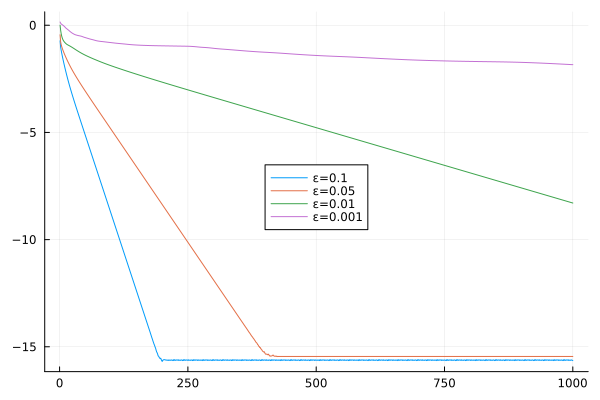

In [ ]:
plt = plot(legend=:inside)
for epsilon in [.1, .05, .01, .001]
    P, Err =  Sinkhorn(C, epsilon, zeros(n), 1000)
    plot!(plt, log10.(Err), label="ε=$epsilon")
end
display(plt)

Wasserstein Flow for Matching
------------------------------

We aim to perform a **"Lagrangian" gradient descent** (also known as a **Wasserstein flow**) on the Wasserstein distance, in order to carry out a **non-parametric fitting** of a measure to a target distribution.

This corresponds to minimizing the following energy function:
$$
\mathcal{E}(z) := W_\epsilon\left( \frac{1}{n} \sum_i \delta_{z_i}, \frac{1}{m} \sum_i \delta_{y_i} \right),
$$
where:
- $z = (z_i)_{i=1}^n$ are the particles we optimize,
- $(y_i)_{i=1}^m$ are fixed target points,
- $W_\epsilon$ is the entropic regularized Wasserstein distance.

We denote the **Sinkhorn loss** as:
$$
W_\epsilon(\alpha, \beta) := \langle P, C \rangle - \epsilon \, \mathrm{KL}(P \,\|\, a b^\top),
$$
where:
- $\alpha = \frac{1}{n} \sum_i \delta_{x_i}$ and $\beta = \frac{1}{m} \sum_i \delta_{y_i}$ are the source and target empirical measures,
- $C$ is the cost matrix, which depends on the positions $z_i$ and $y_j$,
- $P$ is the optimal transport plan,
- $\mathrm{KL}(P \,\|\, ab^\top)$ is the Kullback-Leibler divergence between $P$ and the product of marginals.

By computing the gradient of $\mathcal{E}(z)$ with respect to $z$, we can evolve the particles in a way that aligns them with the target distribution in Wasserstein space.

In [ ]:
z = x; # initialization

The **gradient of the energy** $\mathcal{E}(z)$ with respect to the particle positions $z$ is given by:
$$
(\nabla \mathcal{E}(z))_i = \sum_j P_{i,j}(z_i - y_j) = a_i z_i - \sum_j P_{i,j} y_j,
$$
where $P$ is the optimal coupling obtained via Sinkhorn, and $a_i = 1/n$ under uniform weights.

However, it is preferable to use a **renormalized gradient**, which corresponds to defining the inner product on the deformation field with respect to the source measure $a$. This leads to:
$$
(\bar{\nabla} \mathcal{E}(z))_i = z_i - \bar{y}_i, \quad \text{where} \quad
\bar{y}_i := \frac{\sum_j P_{i,j} y_j}{a_i}.
$$

The vector $\bar{y}_i$ is known as the **barycentric projection** of $z_i$ through the coupling matrix $P$. It represents the mass-weighted average of the target locations $y_j$ transported from $z_i$.

*Implementation Note*:  To compute the gradient descent flow using Sinkhorn, make sure to:
- Recompute the **cost matrix $C$** at each iteration since it depends on the current particle positions $z$,
- Run Sinkhorn to get the updated coupling $P$ at each step,
- Compute the barycentric projections $\bar{y}_i$ using $P$,
- Update $z_i$ using a step in the direction $z_i - \bar{y}_i$.

In [ ]:
epsilon = .01
niter = 300
P, Err = Sinkhorn(distmat(z,y), epsilon, zeros(n), niter);

Compute the gradient

In [ ]:
G = z .- ( y * P' ) ./ a';

Display the gradient field.

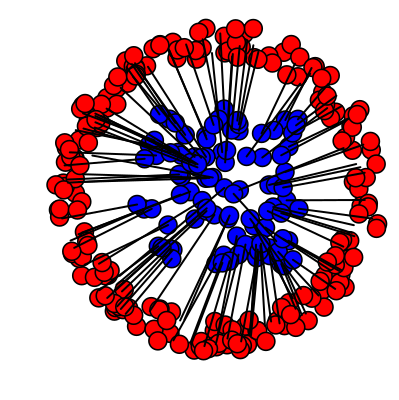

In [ ]:
plt = plot(size=(400, 400), aspect_ratio=:equal, border=:none)
plotp!(plt, x, :blue)
plotp!(plt, y, :red)
# Plot connections
for i in 1:n
    plot!(
        plt,
        [x[1, i], x[1, i] - G[1, i]],
        [x[2, i], x[2, i] - G[2, i]],
        linecolor=:black,
        linewidth=2
    )
end
display(plt)

Set the descent step size.

In [ ]:
tau = .1;

Update the point cloud.

In [ ]:
z = z .- tau .* G;

We now implement the gradient flow.

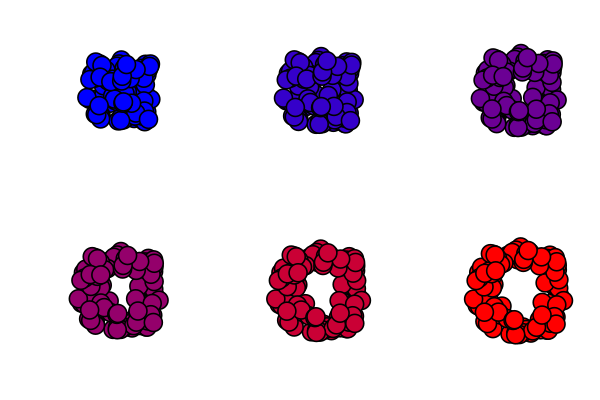

In [ ]:
z = x # initialization
tau = .03 # step size for the descent
giter = 20 # iter for the gradient descent
ndisp = round.(Int, LinRange(1, giter, 6))
kdisp = 1
f = zeros(n) # use warm restart in the following

plt = plot(
    layout=(2,3),
    aspect_ratio=:equal,
    border=:none,
    xlims=extrema(y[1,:]) .* 1.1,
    ylims=extrema(y[2,:]) .* 1.1
)

for j in 1:giter
    # drawing
    if ndisp[kdisp] == j
        s = (j - 1) / (giter- 1)
        col = RGB(s, 0, 1 - s)
        plotp!(plt[kdisp], z, col)
        kdisp = kdisp + 1
    end
    # Sinkhorn
    P, Err = Sinkhorn(distmat(z, y), epsilon, f, niter);
    # gradient
    G = z .- (y * P') ./ a';
    z = z .- tau .* G;
end

display(plt)

We now show the **evolution of the fit** as the regularization parameter $\epsilon$ increases.

To better capture the geometry of the Wasserstein space and remove the entropic bias, we replace the **Sinkhorn score** $W_\epsilon(\alpha, \beta)$ with the **Sinkhorn divergence**:
$$
\mathrm{S}_\epsilon(\alpha, \beta) := W_\epsilon(\alpha, \beta)
- \frac{1}{2} W_\epsilon(\alpha, \alpha)
- \frac{1}{2} W_\epsilon(\beta, \beta).
$$

This divergence is symmetric, positive definite, and equals zero if and only if $\alpha = \beta$. It provides a more faithful measure of distance between probability measures compared to the raw Sinkhorn loss, especially for larger $\epsilon$.

This illustrates the trade-off between **precision** and **regularity** in entropic regularization.

In [ ]:
## Insert your code here.

Generative Model Fitting
------------------------

This Wasserstein distance is a **non-parametric idealization** that does not directly correspond to most practical applications.

To explore a practical case, we consider a simple **toy example of density fitting**, where the goal is to optimize a **parametric transformation** $g_\theta$ to fit a **deformed point cloud** $(g_\theta(x_i))_i$ to a target distribution using the Sinkhorn divergence.

This setting appears in machine learning as a basic form of a **generative model**, and in imaging it corresponds to **shape registration**.


### Optimization Problem

The matching is achieved by solving:
$$
\min_\theta \mathcal{F}(\theta) := \mathcal{E}(G_\theta(z)) = W_\epsilon\left( \frac{1}{n} \sum_i \delta_{g_\theta(z_i)}, \frac{1}{m} \sum_i \delta_{y_i} \right),
$$
where $G_\theta(z) = (g_\theta(z_i))_i$ operates pointwise on each $z_i$.

### Gradient Expression

The gradient of this objective with respect to the parameters $\theta$ is:
$$
\nabla \mathcal{F}(\theta) = \sum_i \partial g_\theta(z_i)^* \left[ \nabla \mathcal{E}(G_\theta(z))_i \right],
$$
where $\partial g_\theta(z_i)^*$ is the adjoint of the Jacobian of $g_\theta$ at $z_i$, and $\nabla \mathcal{E}$ is the gradient of the Sinkhorn loss with respect to the transformed point positions.


### Affine Model

We now consider a **simple affine model** for the transformation:
- Parameters: $\theta = (A, h) \in \mathbb{R}^{d \times d} \times \mathbb{R}^d$
- Transformation: $g_\theta(z_i) = A z_i + h$

Let $v_i = \nabla \mathcal{E}(G_\theta(z))_i$ denote the gradient of the Sinkhorn energy with respect to $g_\theta(z_i)$, computed as in the previous section (via barycentric projection).

Then, the gradients of the objective with respect to $A$ and $h$ are:
$$
\nabla_A \mathcal{F}(\theta) = \sum_i v_i z_i^\top, \quad
\nabla_h \mathcal{F}(\theta) = \sum_i v_i.
$$

This structure enables efficient optimization using gradient descent in the parameter space.

Generate the data.

In [ ]:
z = randn(2,n) .* .2
y = randn(2,m) .* .2
y[1,:] = y[1,:] .* .05 .+ 1;

Initialize the parameters.

In [ ]:
A = diagm(ones(2))
h = zeros(2);

Display the clouds.

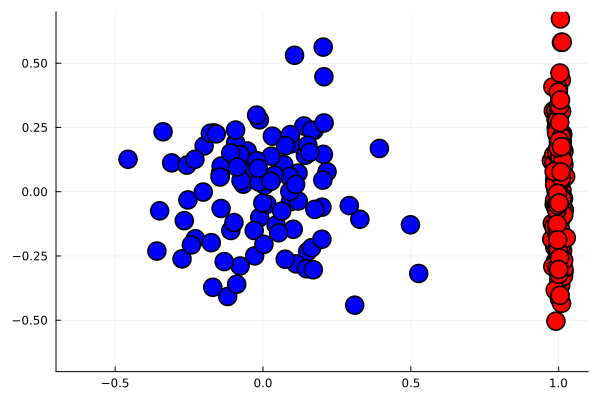

In [ ]:
plt = plot(xlim=[-.7, 1.1], ylim=[-.7,.7])
plotp!(plt, A * z, :blue)
plotp!(plt, y, :red)

Run Sinkhorn.

In [ ]:
x = A * z
f = zeros(n)
P, Err = Sinkhorn(distmat(x, y), epsilon, f, niter);

Compute gradient with respect to positions.

In [ ]:
v = a' .* x .- y * P';

gradient with respect to parameters

In [ ]:
nabla_A = v * z'
nabla_h = sum(v, dims=2);

We now implement the gradient descent.

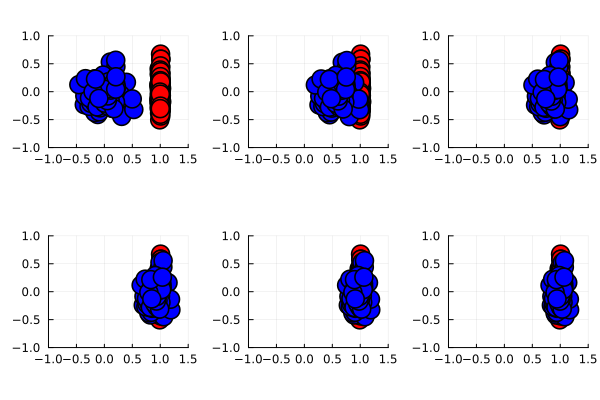

In [ ]:
A = diagm(ones(2))
h = zeros(2)
# step size for the descent
tau_A = .8
tau_h = .1
# iter for the gradient descent
giter = 40
ndisp = round.(Int, LinRange(1, giter, 6))
kdisp=1
f = zeros(n)

plt = plot(
    layout=(2,3),
    aspect_ratio=:equal,
    xlims=(-1, 1.5),
    ylims=(-1, 1)
)

for j in 1:giter
    x = A * z .+ h
    if ndisp[kdisp] == j
        plotp!(plt[kdisp], y, :red)
        plotp!(plt[kdisp], x, :blue)
        kdisp += 1
    end
    P, Err = Sinkhorn(distmat(x, y), epsilon, f, niter)
    v = a' .* x .- y * P'
    nabla_A = v * z'
    nabla_h = sum(v, dims=2)
    A -= tau_A .* nabla_A
    h -= tau_h .* nabla_h
end

display(plt)

Bonus: test using a more complicated deformation (for instance a square being deformed by a random $A$.